# Food Deserts in Pasadena, California

## Table of Contents

* [Problem and Background](#ProblemAndBackground)
* [Data and Methodology](#DataAndMethodology)
  * [Libraries](#Libraries)
  * [City Borders](#CityBorders)
  * [Getting Ready For Foursquare](#GettingReadyForFoursquare)
  * [GeoJSON and shapely](#GeoJSONAndShapely)
  * [Getting data from Foursquare](#GettingDataFromFoursquare)
  * [Cleaning the Venue Data](#CleaningTheVenueData)
* [Analysis](#Analysis)
  * [Histogram](#Histogram)
  * [K Means Clustering](#KMeansClustering)

## Problem and Background <a name="ProblemAndBackground"></a>

A food desert is "... an area that has limited access
to affordable and nutritious food, in contrast with an
area with higher access to supermarkets or vegetable shops
with fresh foods". [Wikipedia](https://en.wikipedia.org/wiki/Food_desert)

The city of Pasadena, California is approximately 10 miles
northeast of downtown Los Angeles, in the foothills of the
San Gabriel mountains. It has an estimated population of
141,000 people [Wikipedia](https://en.wikipedia.org/wiki/Pasadena,_California).

Pasadena has many, many restaurants. If someone was interested
in opening a restaurant in the area, I would advise them to go
elsewhere. However, there are parts of Pasadena that do not have a lot of grocery
stores, and so this report looks to see if there are any 
food deserts in Pasadena, and recommend areas where new
grocery stores could be opened.

## Data and Methodology <a name="DatAndMethodology"></a>


Several sources of data are used. First, the city of Pasadena's own
database of city borders, which is discussed in detail below.
Second, the Foursquare API will be used to find existing grocery
stores within the city's boundaries. 

### Libraries <a name="Libraries"></a>

In addition to the commonly used data science python libraries, I use
the shapely library to help with the data from Foursquare. The need for this is
documented in greater detail further down. 

In [32]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import requests
from pandas import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from math import sqrt

# additional libraries
from shapely.geometry import shape, Point
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
# This is sometimes a little slow

address = "Pasadena, California"
geolocator = Nominatim(user_agent="Coursera_Capstone")
location = geolocator.geocode(address)
if location is not None:
    latitude = location.latitude
    longitude = location.longitude
    print("The coordinates of Pasadena are latitude {}, longitude {}".format(latitude, longitude))
else:
    print("Coordinates not found!")

The coordinates of Pasadena are latitude 34.1476452, longitude -118.1444779


### City Borders <a name="CityBorders"></a>

The city of Pasadena has an open data web site [https://data.cityofpasadena.net]
which includes a downloadable GeoJSON file that defines the city's borders. 
A copy of the file that I downloaded in December of 2020 has been included in the
Github repository for this project. The code in the Notebook works with a local copy.


In [36]:
map_pasadena = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(map_pasadena)
map_pasadena

### Getting Ready for Foursquare <a name="GettingReadyForFoursquare"></a>

It's tempting at this point to take the 8 zip codes that make up Pasadena, find the longitude and latitude of their centers, and query Foursqure for venues. The problem with this approach is that currently Foursquare limits API calls to 50 venues per query, and Pasadena's zip are so large that search results hit that limit. The next block of code breaks Pasadena down into a grid of much smaller 1/2 kilometer chunks, which are the starting point for getting data from Foursquare.

This required me to upgrade my Foursquare account to a "verified" account, because otherwise I would hit the 950 API call per day limit. 

I also had to limit the search to the "Food & Drink Shop" category, because otherwise I still hit the 50 venue limit. 

### GeoJSON and shapely <a name="GeoJSONAndShapely"></a>

After doing all the work, I learned of the existance of GeoPandas, which does a better job of integrating shapely and pandas than what I've done here. That's life with python: 90% of the time someone else has already done the work for you.

Using the city's GeoJSON file, shapely library, and numpy's linspace() method, I create a grid of points that
I will use to search Foursquare. The same grid will be used later to analyze the results.

In [37]:
with open('City_Boundary.geojson') as f:
    pasadena_gj = json.load(f)

# GeoJSON files encode data longitude, latitude (rather than
# the other way around). So, to check if a point in my grid is within
# Pasadena using shapely, I have to reverse the order when
# creating the point

polygon = shape(pasadena_gj['features'][0]['geometry'])

# the purpose of this code is to create a dataframe of the 
# coordiates that make up the coordinates defined by the 
# geojson file, which I will then use to find the extreme
# edges of the city. Feels a little like overkill to use a
# dataframe to find the min and max of some values, but the
# data set is relatively small so I'm not going to worry about
# that. 

coordinates_dict = {"longitude":[], "latitude":[]}
        
for c in pasadena_gj['features'][0]['geometry']['coordinates'][0][0]:
    coordinates_dict['longitude'].append(c[0])
    coordinates_dict['latitude'].append(c[1])

coordinates_df = pd.DataFrame(coordinates_dict)

lat_min = coordinates_df['latitude'].min()
lat_max = coordinates_df['latitude'].max()

long_min = coordinates_df['longitude'].min()
long_max = coordinates_df['longitude'].max()

# The city is roughly 14.5 kilometers wide (at its widest)
# and roughly 11.3 kilometers tall (at its tallest)
# Using linspace, I  create a grid of points roughly
# 500 meters apart and then (more on this later)
# use that grid to search Foursquare

latitudes = np.linspace(lat_min, lat_max, 30)
longitudes = np.linspace(long_min, long_max, 24)

In [38]:
# quick check to verify that the grid does what I want

map_of_grid = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(map_of_grid)

number_of_points = 0

# we'll need this list later

search_points = []

for lat in latitudes:
    for long in longitudes:
        point = Point(long, lat)
        if polygon.contains(point):
            search_points.append((lat, long))
            number_of_points += 1
            label_text = "{}, {}".format(lat, long)
            label = folium.Popup(label_text, parse_html=True)
            folium.CircleMarker(
                [lat, long],
                radius=5,
                popup=label,
                color='red',
                fill=True,
                fill_color='red',
                fill_opacity=0.7).add_to(map_of_grid)

# we will use this later in analysis

search_points_df = pd.DataFrame(search_points, columns=['SP Latitude', 'SP Longitude'])
            
print("Total Number of Points: %d" % (number_of_points))            
            
map_of_grid

Total Number of Points: 218


In [39]:
# save this for later

search_points_df.head()

,SP Latitude,SP Longitude
0,34.121789,-118.140670
1,34.121789,-118.134896
2,34.126319,-118.175311
3,34.126319,-118.163764
4,34.126319,-118.157990


### Getting data from Foursquare <a name="GettingDataFromFoursquare"></a>

Finally time to actually query Foursquare. 

In [40]:
CLIENT_ID = 'ZWNOEXV5OG0240EV0Y5YERTPBTWOQRMEG2ZEV5DQR5D2IHTJ' # my Foursquare ID
CLIENT_SECRET = 'O1BJBPD2QA5QAC3VDVFBXS1J1GAGISXTY5BQKZOKAXUEPM2W' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # the maximum allowed as of this writing
RADIUS = 500 # in meters
CATEGORIES = '4bf58dd8d48988d1f9941735' # this is "Food & Drink Shop", per the API documentation

# You don't see a lot of object oriented programming in 
# data science. Not sure why that is.

class Venue():
    def __init__(self, name, lat, long, category, id):
        self.name = name
        self.latitude = lat
        self.longitude = long
        self.category = category
        self.id = id
        self.distance = 0.0
        
    def __str__(self):
        return "[{}, {}, {}, {}, {}, {}]".format(self.name,
                                        self.category,
                                        self.id,
                                        self.latitude,
                                        self.longitude,
                                        self.distance)

def get_venues(lat, long):
    venues_list = []

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        RADIUS, 
        LIMIT,
        CATEGORIES)
    results = requests.get(url).json()
    
    if (results['response']
                and results['response']['groups']
                and results['response']['groups'][0]
                and results['response']['groups'][0]['items']):
        raw_venues = results['response']['groups'][0]['items']
        if len(raw_venues) == 50:
            print("\nHIT THE LIMIT\n")
        for r in raw_venues:
            v = Venue(r['venue']['name'],
                      r['venue']['location']['lat'],
                      r['venue']['location']['lng'],
                      r['venue']['categories'][0]['name'],
                      r['venue']['id'])
            venues_list.append(v)
        
    return venues_list

In [41]:
number_of_api_calls = 0

my_venues = []

for i, row in search_points_df.iterrows():
    for v in get_venues(row['SP Latitude'], row['SP Longitude']):
        # Any operation that takes more than 5 seconds needs
        # some kind of visual feedback to indicate that work
        # is being done, as opposed to code spinning in an
        # infinite loop
        print(".", end="")
        my_venues.append((v.name, v.latitude, v.longitude,
                          v.category, v.id))
        number_of_api_calls += 1


print("\nUsed the API {} times".format(number_of_api_calls))

print("Loaded {} venues".format(len(my_venues)))

.............................................................................................................................................................................................................................................................................................................................................
Used the API 333 times
Loaded 333 venues


In [45]:
# convert the list to a dataframe

venues_df = pd.DataFrame(data=my_venues,
                         columns=['Venue Name', 'Venue Latitude',
                                  'Venue Longitude', 'Venue Category',
                                  'Venue ID'])    

print(venues_df.shape)
print(venues_df.head())

(333, 5)
                  Venue Name  Venue Latitude  Venue Longitude  \
0         Raymond Restaurant       34.124552      -118.150038   
1  Gerlach's Drive-In Liquor       34.127421      -118.150592   
2         Raymond Restaurant       34.124552      -118.150038   
3                     BevMo!       34.130553      -118.147717   
4  Gerlach's Drive-In Liquor       34.127421      -118.150592   

        Venue Category                  Venue ID  
0  American Restaurant  4b78620bf964a52012ca2ee3  
1         Liquor Store  4bd790dd09ecb713e940477c  
2  American Restaurant  4b78620bf964a52012ca2ee3  
3         Liquor Store  4a79bd12f964a52081e71fe3  
4         Liquor Store  4bd790dd09ecb713e940477c  


### Cleaning the Venue Data <a name="CleaningTheVenueData"></a>

The method of retrieving venues has resulted in some issues.
First, there are occasionally duplicates, beause the search area
for each point overlaps with the areas of the adjacent 
points.

During manual review of the venue data I discovered that some venues were returned
that I'm not interested in, like a sushi restaurant. So 
the list of categories was manually reviewed and venues with 
unwanted values removed. 

Lastly, one venue is actually closed. We don't need that one. 

In [46]:
# A sanity check. Even though the query was
# limited to the "Food & Drink Shop" category, while reviewing the results
# I noticed that a few restaraunts and other venues were included.
# I print out the unique values of categories, and then manually
# remove a few (i.e. "Sushi Restaurant").

venues_df['Venue Category'].unique()

array(['American Restaurant', 'Liquor Store', 'Grocery Store',
       'Deli / Bodega', 'Food & Drink Shop', 'Wine Shop', 'Gourmet Shop',
       'Health Food Store', 'Kitchen Supply Store', 'Farmers Market',
       'Supermarket', 'Coffee Shop', 'Juice Bar', 'Food Service',
       'Wine Bar', 'Sushi Restaurant', 'Seafood Restaurant', 'Bakery',
       'Supplement Shop', 'Café', 'Gift Shop', 'Pizza Place', 'Tea Room',
       'Fast Food Restaurant', 'Big Box Store', 'Furniture / Home Store',
       'Butcher', 'Fish Market', 'Restaurant', 'Organic Grocery'],
      dtype=object)

In [47]:
print("Rows at start: {}".format(venues_df.shape[0]))
venues_df.drop_duplicates()

print("Rows after dropping duplicates: {}".format(venues_df.shape[0]))
# this venue has been closed for many years, so it is removed.

venues_df.drop(venues_df.loc[venues_df['Venue ID'] == '4b68bf44f964a520968a2be3'].index, 
               inplace=True)

# similarly, these venues aren't stores, so we remove them

venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'American Restaurant'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Kitchen Supply Store'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Farmers Market'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Juice Bar'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Wine Bar'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Sushi Restaurant'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Seafood Restaurant'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Supplement Shop'].index,
               inplace = True) 
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Café'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Gift Shop'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Pizza Place'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Tea Room'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Fast Food Restaurant'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Furniture / Home Store'].index,
               inplace = True)
venues_df.drop(venues_df.loc[venues_df['Venue Category'] == 'Liquor Store'].index,
               inplace = True)

print("Rows after dropping unwanted categories: {}".format(venues_df.shape[0]))
print("List of categories retained: ", venues_df['Venue Category'].unique())

Rows at start: 333
Rows after dropping duplicates: 333
Rows after dropping unwanted categories: 197
List of categories retained:  ['Grocery Store' 'Deli / Bodega' 'Food & Drink Shop' 'Wine Shop'
 'Gourmet Shop' 'Health Food Store' 'Supermarket' 'Coffee Shop'
 'Food Service' 'Bakery' 'Big Box Store' 'Butcher' 'Fish Market'
 'Restaurant' 'Organic Grocery']


In [48]:
# Time to make a map. This list of colors comes from the folium
# documentation.

colors = ['red', 'blue', 'green', 
          'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 
          'darkgreen', 'cadetblue', 'darkpurple', 
          'white', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 
          'lightgray']

color_map = dict(zip(venues_df['Venue Category'].unique(), colors))

groceries_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(groceries_map)

# We double check that all venues are in Pasadena, and filter out the 
# venues in categories we don't want.

for i, v in venues_df.iterrows():
    point = Point(v['Venue Longitude'], v['Venue Latitude'])
    if polygon.contains(point):
        label_text = "{} ({}) ({})".format(v['Venue Name'], 
                                           v['Venue Category'], 
                                           v['Venue ID'])
        label = folium.Popup(label_text, parse_html=True)
        folium.CircleMarker(
            [v['Venue Latitude'], v['Venue Longitude']],
            radius=5,
            popup=label,
            color=color_map[v['Venue Category']],
            fill=True,
            fill_color=color_map[v['Venue Category']],
            fill_opacity=0.7).add_to(groceries_map)
    else:
        venues_df.drop(i, inplace=True)

print(venues_df.shape)
groceries_map

(193, 5)


## Analysis <a name="Analysis"></a>

In the map of venues, there are clearly parts of the city that do not
have any kind of food stores. We need to quantify
that. First, for each point
in the search grid, we're going to find the closest store, and 
build a dataframe with the values for the closest venue.

Also, it isn't surprising that the area to the north west does not have any 
supermarkets, as it is mostly taken up by a park and sports arena. However,
there are residential neighborhoods on either side.



In [49]:
# Shapely has a distance() function that would work nicely for
# our purposes, if longitude and latitude formed a perfect grid.
# But they do not: 1 degree of latitude is roughly 88 kilometers
# at Pasadena, while 1 degree of longitude is 110.5 kilometers.
# Which means to get the distance between a grocery store and a
# point in the search grid I first need to convert degrees
# to kilometers

from math import sqrt

def calculate_distance(sp_latitude, sp_longitude, cv_latitude, cv_longitude):
    deg_latitude = sp_latitude - cv_latitude
    deg_longitude = sp_longitude - cv_longitude
    km_latitude = deg_latitude * 110.5
    km_longitude = deg_longitude * 85
    distance = sqrt(km_latitude**2 + km_longitude**2)
    return distance



In [50]:
# we need to do two things: find the closest venue
# for each search point, and build a new dataframe
# that will be used for analysis that merges the 
# search_points_df and venues_df

# in this dataframe, "SP" is short for "Search Point" and 
# and "CV" is short for "Closest Venue"

analysis_data = []
closest_venue = []

for sp_i, sp_r in search_points_df.iterrows():
    current_distance = 100
    new_distance = 0
    print(".", end="")
    for v_i, v_r in venues_df.iterrows():
        new_distance = calculate_distance(sp_r['SP Latitude'],
                               sp_r['SP Longitude'],
                               v_r['Venue Latitude'],
                               v_r['Venue Longitude'])
        if new_distance < current_distance:
            closest_venue = list(v_r)
            current_distance = new_distance
            
            
    analysis_data.append({'SP Latitude':sp_r['SP Latitude'],
                          'SP Longitude':sp_r['SP Longitude'],
                          'CV Name':closest_venue[0],
                          'CV Latitude':closest_venue[1],
                          'CV Longitude':closest_venue[2],
                          'CV Category':closest_venue[3],
                          'CV ID':closest_venue[4],
                          'CV Distance':current_distance})

analysis_df = pd.DataFrame(analysis_data, columns=['SP Latitude',
                                                 'SP Longitude',
                                                 'CV Name',
                                                 'CV Latitude',
                                                 'CV Longitude',
                                                 'CV Category',
                                                 'CV ID',
                                                 'CV Distance'])
print("\n")
print(analysis_df.shape)
analysis_df.head()
                    

..........................................................................................................................................................................................................................

(218, 8)


,SP Latitude,SP Longitude,CV Name,CV Latitude,CV Longitude,CV Category,CV ID,CV Distance
0,34.121789,-118.140670,Trader Joe's,34.135222,-118.147142,Grocery Store,4ae277bdf964a5207a8e21e3,1.583004
1,34.121789,-118.134896,Papa Georges Gary's Mini Market,34.136091,-118.131883,Deli / Bodega,4b8a2870f964a520406232e3,1.601040
2,34.126319,-118.175311,The Kitchen For Exploring Foods,34.140728,-118.178710,Food & Drink Shop,4bad4fd6f964a52003453be3,1.618181
3,34.126319,-118.163764,Asia World,34.136640,-118.153615,Grocery Store,5d278c4a9d81e3002380b813,1.429979
4,34.126319,-118.157990,Asia World,34.136640,-118.153615,Grocery Store,5d278c4a9d81e3002380b813,1.199572


### Histogram <a name="Histogram"></a>

Before doing any really deep analysis, a simple histogram 
is helpful.

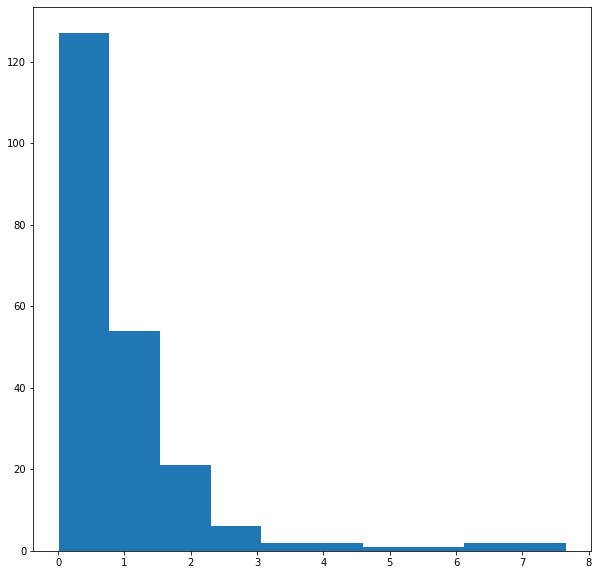

In [51]:
# A quick histogram suggests we're on the 
# right track - most of the city has adequate access
# to fresh food, but we will dive deeper

fig = plt.figure(figsize=(10, 10))
xticks = np.linspace(0, 11, 8, endpoint=True)
ax = fig.add_subplot(1, 1, 1)
ax.hist(analysis_df['CV Distance'], bins=10)
plt.show()

### K Means Clustering <a name="KMeansClustering"></a>

The map looks like there are areas that are good candidates for
a new store, and the histogram suggests that while most of the
city is well served by grocery stores, there are areas that are not. 
We will use K Means clustering
to group the search points by their distance to a venue, and
then re-draw the map of Pasadena with the grid color-coded to 
the clustering.

In [52]:


np_closest = np.array(analysis_df['CV Distance'])
k_means = KMeans(init="k-means++", n_clusters=7, n_init=12)
k_means.fit(np_closest.reshape(-1, 1))
analysis_df['KM Cluster'] = k_means.labels_
print(analysis_df.head())

   SP Latitude  SP Longitude                          CV Name  CV Latitude  \
0    34.121789   -118.140670                     Trader Joe's    34.135222   
1    34.121789   -118.134896  Papa Georges Gary's Mini Market    34.136091   
2    34.126319   -118.175311  The Kitchen For Exploring Foods    34.140728   
3    34.126319   -118.163764                       Asia World    34.136640   
4    34.126319   -118.157990                       Asia World    34.136640   

   CV Longitude        CV Category                     CV ID  CV Distance  \
0   -118.147142      Grocery Store  4ae277bdf964a5207a8e21e3     1.583004   
1   -118.131883      Deli / Bodega  4b8a2870f964a520406232e3     1.601040   
2   -118.178710  Food & Drink Shop  4bad4fd6f964a52003453be3     1.618181   
3   -118.153615      Grocery Store  5d278c4a9d81e3002380b813     1.429979   
4   -118.153615      Grocery Store  5d278c4a9d81e3002380b813     1.199572   

   KM Cluster  
0           2  
1           2  
2           2  
3   

In [53]:
# that looks good. Now let's re-draw the map of the grid
# using the labels to color code the search points

k_means_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(k_means_map)

colors = ['red', 'blue', 'green', 
          'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 
          'darkgreen', 'cadetblue', 'darkpurple', 
          'white', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 
          'lightgray']

for i, row in analysis_df.iterrows():
    color = colors[row['KM Cluster']]
    label_text = str([row['KM Cluster'], color])
    folium.CircleMarker(
        [row['SP Latitude'], row['SP Longitude']],
        radius=5,
        popup=label_text,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(k_means_map)
            
k_means_map

In [61]:
# that map is a little hard to read, so we will customize
# the colors so that points that are close to a grocery store
# are green, points that are a little far are yellow, and
# points that are the farthest away are red

k_means_map = folium.Map(location=[latitude, longitude], zoom_start=12)

folium.GeoJson('City_Boundary.geojson', name='geojson').add_to(k_means_map)

# these colors were arrived at with some experimentation

colors = ['yellow', 'red', 'red', 
          'red', 'red', 'yellow',
          'green', 'beige', 'darkblue', 
          'darkgreen', 'cadetblue', 'darkpurple', 
          'white', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 
          'lightgray']

for i, row in analysis_df.iterrows():
    color = colors[row['KM Cluster']]
    label_text = str([row['KM Cluster'], color])
    folium.CircleMarker(
        [row['SP Latitude'], row['SP Longitude']],
        radius=5,
        popup=label_text,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(k_means_map)
            
k_means_map

## Results and Discussion <a name="ResultsAndDiscussion"></a>

The core of the city of Pasadena has adequate access to fresh food
available at grocery stores. However, there are significant 
segments of the city that do not. 

Most of the western part of the city does not have nearby access
to a grocery store. However, these areas would not be good places
to open a store, as they are dominated by nature parks or the
residents are fairly wealthy and unintersted in having any kind
of commercial development, even if it means a little bit of travel
to buy food necessities.

Similarly, the slender region that extends north from the west
part of the city is mostly rural and not residentials. There is
no need for a grocery store in 

The area in the north east corner of the city is under
served. Several years ago there was a store in this neighborhood,
but it is now close. If it were still open, this region would
be adequately served.

The neighborhoods in the southern part of the city are also understood,
though the situation is a little more complicated than this 
analysis shows. If the analysis had included the city of South Pasadena,
it is possible that the southern neighborhoods of Pasadena
would have been found to be well served. 

The most interesting search poing in the grid is right in the middle.
As it happens this point is in the center of a busy transit corridor
and commercial district. But it is also a neighborhood with dense housing,
and a grocery store would probably do well there.

## Conclusion <a name="Conclusion"></a>

The purpose of this project was to identify neighborhoods that are
underserved by grocery stores, with the goal of identifying locations
where a new venue could do well. Although the city of Pasadena is, 
for the most part, well served by a variety of places to buy food,
there are significant portions that are not. 